# Summary
- [Data](#Data)
- [Model](#Model)
- [Training](#Training)
    - [10-fold-cross-validation](#10-fold-cross-validation)
    - [#Hyperparameters](#Hyperparameters)
- [Visualization](#Visualization)
    - [Interpretation](#Interpretation)
- [Implemented-but-not-used](#Implemented-but-not-used)
    - [Debug](#Debug)

# Dependencies


In [1]:
#visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})#for prettier plots
#math tools
import numpy as np
#machine learning
import torch
from sklearn.model_selection import StratifiedKFold
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("using",device,"device")
#io
from os.path import join
from os.path import exists
from os import makedirs
from os import listdir
import pickle
#utils
from time import time
import warnings
#custom
from modules.utils import *
from modules.load_data import *
from modules.training import *
#models
from modules.model import Model
from modules.encoder import Encoder
from modules.tcn import *
from modules.CNN1d import CNN1d
from modules.HierarchicalCNN1d import HierarchicalCNN1d
from modules.HierarchicalStrokeCNN1d import HierarchicalStrokeCNN1d
from modules.HierarchicalStrokeCRNN import HierarchicalStrokeCRNN
from modules.HierarchicalRNN import HierarchicalRNN

using cuda device


In [2]:
dropout=0.0
input_noise=0.5
hidden_size=[16,32,64]  
conv_kernel= [8,4,3]
pool_kernel=[8,4,3]
dilation= 'redef as 1'#[1,1]
stride='redef as kernel_size'
output_size="foo"
padding=[0,0,0]#"redef as (k-1)//2"#
"""for d,k in list(zip(dilation,conv_kernel)):
    padding.append((k-1)//2)#d*(k-1)//2)"""
input_size=2

In [3]:
class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self,input):
        return input.view(input.size(0), -1)

import torch

class CNNAutoencoder(torch.nn.Module):
    def __init__(self,input_size,hidden_size,conv_kernel,pool_kernel ,padding,
                 stride=1,dilation=1, dropout=0.0,input_noise=0.0):
        super(CNNAutoencoder, self).__init__()
        self.num_layers=len(hidden_size) 
        
        self.noise=torch.nn.Dropout(input_noise)
        layers=[]
        for i, (h,c,p,pad) in enumerate(list(zip(hidden_size,conv_kernel,pool_kernel,padding))):
            s = input_size if i ==0 else hidden_size[i-1]
            layers+=[
                torch.nn.Conv1d(s,h,c,stride=p,padding=pad,dilation=1),
                torch.nn.ReLU(),
                torch.nn.Dropout(dropout)
            ]
        self.encoder=torch.nn.Sequential(*layers)
        
        layers=[]
        for i, (h,c,p,pad) in enumerate(list(zip(hidden_size,conv_kernel,pool_kernel,padding))[::-1]):
            if i ==self.num_layers-1:                
                s= input_size
                layers+=[
                    torch.nn.ConvTranspose1d(h,s,c,stride=p,padding=pad,dilation=1)
                ]
            else :
                s = hidden_size[::-1][i+1]      
                layers+=[
                    torch.nn.ConvTranspose1d(h,s,c,stride=p,padding=pad,dilation=1),
                    torch.nn.ReLU(),
                    torch.nn.Dropout(dropout)
                ]        
        self.decoder=torch.nn.Sequential(*layers)
        
    def forward(self,subject):
        noisy=self.noise(subject)
        code=self.encoder(noisy)
        decode=self.decoder(code)        
        return code,decode#self.sigmoid(d_c1)


# Utils
Cf `utils.py`

In [4]:

def plot(plot_i,train,valid,test,average=True):
    if average:
        print(model_name.replace(",","|"))
        if early_stopping:
            title = "average {} over 10 folds over the {} first epochs".format(index2plot[plot_i],shortest_fold)
        else:
            title = "average {} over 10 folds over {} epochs".format(index2plot[plot_i],n_epochs)
    else :
        train,test=np.asarray(train),np.asarray(test)
        if valid is not None:
            valid=np.asarray(valid)
        title=model_name
    plt.title(title)
    plt.plot(train[:,plot_i],label="training")
    if valid is not None:
        plt.plot(valid[:,plot_i],label="validation")
    plt.plot(test[:,plot_i],label="test")
    plt.xlabel("epochs")
    plt.ylabel(index2plot[plot_i])
    plt.legend()
    if plot_i!=0:
        plt.ylim(0,1)

def return_results(train_metrics,valid_metrics,test_metrics,stopped_at,flat_falses):
    train_metrics,test_metrics=np.asarray(train_metrics),np.asarray(test_metrics)
    if early_stopping:
        valid_metrics=np.asarray(valid_metrics)
        str_valid_metrics="{:.2f} (± {:.2f})".format(np.mean(valid_metrics[:,1]),np.std(valid_metrics[:,1]))
    else:
        str_valid_metrics="NA"
    results="{} ; {} ; {}  ; {} ; {} ; {} ; {} ; {} ; {}; {}  ; {} ; {:.2f} (± {:.2f}); {} ; {} ; {} ; {} ; {} ; {} ; {} ; NA ; {} ; TRUE ; FALSE  ; {:.2f} (± {:.2f}) ; {} ".format(
    task_name,model_type,learning_rate, hidden_size,conv_kernel,pool_kernel,
        num_layers,dilation,bidirectional,dropout,clip,
    np.mean(stopped_at),np.std(stopped_at),max_len,augmentation,paper_air_split,letter_split,pad_subs,
        compute_movement_,early_stopping,downsampling_factor,
     np.mean(train_metrics[:,1]),np.std(train_metrics[:,1]), str_valid_metrics)

    test_metrics=test_metrics.T
    for metric in test_metrics[1:]:#don't care about the loss
        mean,std=np.mean(metric),np.std(metric)
        results+="; {:.2f} (± {:.2f}) ".format(mean,std)
    results+=" ; "
    results+=" ; ".join(map(str, flat_falses))
    return results
def print_results(fold_train_metrics,fold_test_metrics,fold_falses):
    try:
        if early_stopping:
            folds_lengths=[len(fold) for fold in fold_valid_metrics]
            assert True#np.max(folds_lengths) < n_epochs
            print("number of epochs before early stopping for each fold:\n",folds_lengths)
            longest_fold=np.argmax(folds_lengths)
            shortest_fold=np.min(folds_lengths)
            average_stop=int(round(np.mean(folds_lengths)-patience))-1#-1 to index to it
            med_stop=int(round(np.median(folds_lengths)-patience-1))#-1 to index to it
            best_index=-1#-patience-1
            stopped_at=[len(fold)-patience-5 for fold in fold_valid_metrics]
        else:
            shortest_fold=None#fake value so we can return it
            best_index=np.argmax(np.mean(fold_test_metrics,axis=0)[:,1])      
            stopped_at=[best_index+1]
    except AssertionError:
        print("The model didn't early stop therefore fold[-patience-1] is not the best epoch")    
    else:    
        best_falses=[fold[best_index] for fold in fold_falses]
        flat_falses = sorted(flat_list(best_falses))
        results=return_results([fold[best_index] for fold in fold_train_metrics],
                     None, #[fold[best_index] for fold in fold_valid_metrics],
                      [fold[best_index] for fold in fold_test_metrics],
                      stopped_at,
                       flat_falses)
        print(results)
        return shortest_fold,results

# Data
Cf `load_data.py`
## Loading

## Task selection
set `task_i` to None if you want to train the model on all tasks at once (i.e. early fusion)  
Else set `task_i` to the desired task index (cf. task2index)

## Compute movement
Transforms data as Zhang et al. (cf Report #5)

## Scale then downsample (or not) then concatenate task id (or not)
Set `downsampling_factor` to `1` if you don't want to downsample
## Split in subsequence (or not)
Set `window_size` to `None` if you don't want to split data into subsequence of fixed length  
Set `paper_air_split` to `False` if you don't want to split data into strokes  
letter_split is not well-named and corresponds to a token split

In [5]:
## Loading
#Cf `load_data.py`
task_i=1
task_name=index2task[task_i] if task_i is not None else str(task_i)
raw_data_path=join("data","raw_data")
data_path=join("data","stroke_split_{}.npy".format(task_name))#"stroke_split_{}.npy".format(task_name)
target_path=join("data","targets.npy")
compute_speed_accel_=False
compute_movement_=False
downsampling_factor=1
window_size=None#256
paper_air_split=True
letter_split=False
discard_non_letters=False
pad_subs=False
#used to trim and pad the data, Set to None if you don't want to
if letter_split:
    max_len=token_lengths
elif paper_air_split:
    max_len=stroke_lengths 
else:
    max_len=max_lengths
max_len=max_len[task_i] if task_i is not None else max_len
trim=False
if max_len is None and trim:
    warnings.warn("trim is not effective as max_len is None")
if discard_non_letters and pad_subs:
    warnings.warn("discard_non_letters and pad_subs are mutually exclusive, a priori")
if letter_split and not paper_air_split:
    warnings.warn("setting paper_air_split at True as letter_split is !")
    paper_air_split=True
if discard_non_letters and not paper_air_split:
    warnings.warn("setting paper_air_split at True as discard_non_letters is !")
    paper_air_split=True
if window_size is not None and paper_air_split:
    warnings.warn("you have to choose between subsequences of fixed length and strokes !")
if task_i is None and (compute_movement_ or compute_speed_accel_ or window_size is not None or paper_air_split):
    raise NotImplementedError("""compute_movement_ and compute_speed_accel_ 
                              are only implemented for single task learning !
                              Subsequences are not are only implemented for single task learning.""")  
elif discard_non_letters and letter_split:
    raise ValueError("discard_non_letters and letter_split are mutually exclusive ! Set one to False")
elif not exists(data_path):
    if not exists(raw_data_path):
        print("\nloading and massaging data, this might take a few seconds...")
        data_gen=load_data()
        data,targets=[],[]
        for subject,label,_ in data_gen:
            data.append(subject)
            targets.append(label)
        with open(raw_data_path, 'wb') as fp:
            pickle.dump(data, fp)
        targets=np.asarray(targets)
        np.save(target_path,targets)
    else:
        print("loading raw data from",raw_data_path)
        with open(raw_data_path, 'rb') as fp:
            data=pickle.load(fp)
        print("loading targets from",target_path)
        targets=np.load(target_path)
    print("(75-3 subjects, 8 tasks, X timesteps, 7 measures) :")
    print(len(data),len(data[0]),len(data[0][0]),len(data[0][0][0]))
    if compute_movement_ and compute_speed_accel_:
        warnings.warn("Only speed and accel will be computed ! \nSet compute_speed_accel_ to False if you want to compute movement")
    data= massage_data(data,task_i, compute_speed_accel_,compute_movement_,
                                downsampling_factor, window_size,paper_air_split,max_len=max_len,
                                letter_split=letter_split,discard_non_letters=discard_non_letters,pad_subs=pad_subs,trim=trim)
    np.save(data_path,data)
else:
    print("loading data from",data_path)
    data=np.load(data_path)
    print("loading targets from",target_path)
    targets=np.load(target_path)
    print(data.shape,targets.shape)

if window_size is not None:
    seq_len=window_size
elif max_len is not None and trim:
    seq_len=max_len
elif paper_air_split or task_i is None:
    seq_len=max([len(sub) for task in data for sub in task])
else:
    seq_len=max([len(task) for task in data])
n_seq=len(data[0]) if paper_air_split else 1
print("max length, # of sub sequences (may vary):",seq_len,n_seq)

loading data from data/stroke_split_l.npy
loading targets from data/targets.npy
(72,) (72,)
max length, # of sub sequences (may vary): 752 9


In [6]:
load_model = join("weights", #parent directory
                    "('CNNAutoencoder', 0.001, [16, 32, 64], 0.0, [8, 4, 3], [8, 4, 3], 'redef as 1', 0.5)",
                    '{}_checkpoint.tar'.format(49)#epoch to load at
                   )
checkpoint = torch.load(load_model)
model_sd = checkpoint['model']
autoencoder=CNNAutoencoder(input_size,hidden_size,conv_kernel,pool_kernel ,padding,
                           stride,dilation, dropout,input_noise)

In [7]:
for i,subject in enumerate(data):
    data[i]=[]
    for j,sub in enumerate(subject):#sub
        if sub[0][measure2index["button_status"]]==on_paper_value:
            sub=downsample(sub,3)
            data[i].append(sub[:,:2])
        #data[i][j]=np.concatenate((sub,np.zeros(shape=(max_len-len(sub),sub.shape[1]))))

# Model
Cf. classes in `./modules/`  
Cf. Report on the code for details about the architecture of the model

- [**Pytorch LSTM doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.LSTM)
- [**Pytorch GRU doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.GRU)
- [**Pytorch Linear doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear)
- [**Pytorch Binary Cross Entropy loss (BCELoss) doc**](https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss)



# Training
Cf. `training.py`  


## 10 fold cross validation

- set `run_CV` to `False` if you just want to train on one fold.

In [8]:
def CV(run_CV=True,n_epochs=100,data=data,start_at_fold=0,max_len=None):
    """
    run_CV : if False, breaks after one fold, else runs CV
    n_epochs: max n° of epochs the model will be trained to
    """
    verbose=False
    fold_train_metrics,fold_test_metrics,fold_falses=[],[],[]
    fold_train_predictions,fold_test_predictions=[],[]
    start = time()
    np.random.seed(1)
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_generator=skf.split(data,targets)

    for fold,(train_index,test_index) in enumerate(cv_generator): 

        if fold in np.arange(start_at_fold) and not run_CV:
            print("SKIPPING FOLD n°",fold)
            continue
        train_metrics,test_metrics,falses=[],[],[]
        train_predictions,test_predictions=[],[]

        torch.manual_seed(1)#random seed for weights init
        hierarchical=False#except if model_type=="hcnn1d"
        if model_type=="tcn":
            model= TemporalConvNet(input_size,hidden_size,kernel_size,dropout,output_size=1,dilation_factor=dilation_factor)
        elif model_type=="lstm":
            model=Model(input_size, hidden_size[0],num_layers, bias,batch_first,
                         dropout,bidirectional, batch_size,output_size, is_lstm=True)
            model.init_forget_bias()
        elif model_type=="gru":
            model=Model(input_size, hidden_size[0],num_layers, bias,batch_first,
                         dropout,bidirectional, batch_size,output_size, is_lstm=False)
        elif model_type=="hrnn":
            hierarchical=True
            model=HierarchicalRNN(input_size, hidden_size[0], bias,
                         dropout, batch_size,output_size, is_lstm=True)
        elif model_type=="pretrained":
            load_model = join("weights", #parent directory
                    "('CNNAutoencoder', 0.001, [16, 32, 64], 0.0, [8, 4, 3], [8, 4, 3], 'redef as 1', 0.5)",
                    '{}_checkpoint.tar'.format(49)#epoch to load at
                   )
            checkpoint = torch.load(load_model)
            model_sd = checkpoint['model']
            autoencoder=CNNAutoencoder(input_size,hidden_size,conv_kernel,pool_kernel ,padding,
                                       stride,dilation, dropout,input_noise)
            autoencoder.load_state_dict(model_sd)
            model = torch.nn.Sequential(
                torch.nn.Dropout(input_noise),
                autoencoder.encoder,
                Flatten(),
                torch.nn.Linear(192,1),
                torch.nn.Sigmoid())
            #freeze encoder weights
            """for param in model[1].parameters():
                param.requires_grad = False"""
        elif model_type=="cnn1d":
            model=CNN1d(input_size,conv_seq_len,hidden_size,conv_kernel,pool_kernel ,padding,stride,dilation, dropout,output_size)
        elif model_type=="hcnn1d":
            hierarchical=True
            model=HierarchicalCNN1d(input_size,conv_seq_len,hidden_size
                                    ,conv_kernel,pool_kernel  ,padding,stride,dilation, dropout,output_size)
        elif model_type=="hscnn1d":
            hierarchical=True
            model=HierarchicalStrokeCNN1d(input_size,conv_seq_len,hidden_size
                                    ,conv_kernel,pool_kernel  ,padding,stride,dilation, dropout,output_size)  
        elif model_type=="hsclstm":
            hierarchical=True
            model=HierarchicalStrokeCRNN(input_size,conv_seq_len,hidden_size,conv_kernel,pool_kernel,
                                         padding,stride,dilation, dropout,bidirectional,output_size, is_lstm=True)
        elif model_type=="hscgru":
            hierarchical=True
            model=HierarchicalStrokeCRNN(input_size,conv_seq_len,hidden_size,conv_kernel,pool_kernel,
                                         padding,stride,dilation, dropout,bidirectional,output_size, is_lstm=False)             
        else:
            raise ValueError("got {} as model_type but expected one of {}".format(model_type,model_types))
        model=model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        if fold==0:        
            print("(total n° of parameters, n° of trainable parameters) :")
            print(count_params(model))   
            print("architecture :")
            print(model)
        for i in range(n_epochs):  
            np.random.shuffle(train_index)#shuffle training to facilitate SGD        
            #training
            model.train()
            condition_targets,predictions,loss=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, train_index,device=device,
                clip=clip,validation=False,window_size=window_size,task_i=task_i,augmentation=augmentation,
                paper_air_split=paper_air_split,hierarchical=hierarchical,max_len=max_len)
            train_predictions.append(predictions)
            #compute metrics
            tn, fp, fn, tp, _ = confusion_matrix(y_true=condition_targets,y_pred=np.around(predictions))
            accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
            train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])

            #test
            model.eval()
            condition_targets,predictions,loss=epoch(
                data, targets, model, optimizer, loss_fn, batch_size, test_index,device=device,
                validation=True,window_size=window_size,task_i=task_i,augmentation=None,
                paper_air_split=paper_air_split,hierarchical=hierarchical,max_len=max_len) 
            test_predictions.append(predictions)
            #compute metrics
            tn, fp, fn, tp, false_i = confusion_matrix(y_true=condition_targets,y_pred=np.around(predictions))
            accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
            false=[test_index[i] for i in false_i]
            test_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
            falses.append(false)  

        fold_train_metrics.append(train_metrics)
        fold_train_predictions.append(train_predictions)
        fold_test_metrics.append(test_metrics)
        fold_test_predictions.append(test_predictions)
        fold_falses.append(falses)
        if not run_CV:
            print("Done. Spent",timeSince(start))
            return train_metrics,test_metrics,model,train_predictions,test_predictions

    if run_CV:   
        # Save metrics
        filename=join("experiments",model_name)
        for metrics,metric_type in list(zip([fold_train_metrics,
        fold_test_metrics],["train","test"])):
            with open(filename+metric_type, 'wb') as fp:
                pickle.dump(metrics, fp)

        shortest_fold,results=print_results(fold_train_metrics,fold_test_metrics,fold_falses) 
        with open("results.csv","a") as file:
            file.writelines(results+"\n")
        print("Done. Spent",timeSince(start))
        return fold_train_metrics,fold_test_metrics,model,fold_train_predictions,fold_test_predictions

def MajorityVoting(model_train_predictions,model_test_predictions,n_epochs=100,round_before_voting=True):
    voted_train_predictions=ReshapeAndVote(model_train_predictions,round_before_voting)
    voted_test_predictions=ReshapeAndVote(model_test_predictions,round_before_voting)
    np.random.seed(1)
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_generator=skf.split(data,targets)
    fold_train_metrics,fold_test_metrics,fold_falses=[],[],[]
    for fold,(train_index,test_index) in enumerate(cv_generator): 
        #print(test_index)
        train_metrics,test_metrics,falses=[],[],[]
        for i in range(n_epochs):  
            np.random.shuffle(train_index)#shuffle training to match CV 
            #TRAIN
            tn, fp, fn, tp, _ = confusion_matrix(y_true=targets[train_index],y_pred=voted_train_predictions[fold][i])
            accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
            train_metrics.append([0,accuracy,sensitivity,specificity,ppv,npv])
            #TEST
            #compute metrics
            tn, fp, fn, tp, false_i = confusion_matrix(y_true=targets[test_index],y_pred=voted_test_predictions[fold][i])
            accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
            false=[test_index[i] for i in false_i]
            test_metrics.append([0,accuracy,sensitivity,specificity,ppv,npv])
            falses.append(false)  
        fold_train_metrics.append(train_metrics)
        fold_test_metrics.append(test_metrics)
        fold_falses.append(falses)
    shortest_fold,results=print_results(fold_train_metrics,fold_test_metrics,fold_falses) 
    with open("results.csv","a") as file:
        file.writelines(results+"\n")
    filename=join("experiments","voting"+model_name)
    for metrics,metric_type in list(zip([fold_train_metrics,
    fold_test_metrics],["train","test"])):
        with open(filename+metric_type, 'wb') as fp:
            pickle.dump(metrics, fp)
    return fold_train_metrics,fold_test_metrics
"""
filename=join("predictions",model_name)
predictions=[]
for metric_type in ["train","test"]:
    with open (filename+metric_type, 'rb') as fp:
        predictions.append(pickle.load(fp))"""

'\nfilename=join("predictions",model_name)\npredictions=[]\nfor metric_type in ["train","test"]:\n    with open (filename+metric_type, \'rb\') as fp:\n        predictions.append(pickle.load(fp))'



## Hyperparameters
The hyperparameters are not always relevant for the chosen `model_type`.  
In this case they won't matter. Give them a random value.  
Choose `model_type` from `models`.  

In [9]:
ranges={
    "learning_rate":[1e-3,1e-4],
    "dropout":np.arange(0,0.6,0.1),
    "hidden_size":[2**i for i in range(2,6)],
    "dilation":[2**i for i in range(5)],
    "conv_kernel":[2**i for i in range(5)],
    "pool_kernel":[2**i for i in range(0,10)],
}
print(ranges)
print("total n° of combinations :", np.prod([len(i) for i in ranges.values()]+[len(j) for j in list(ranges.values())[2:]]))
choices=ranges.copy()

{'learning_rate': [0.001, 0.0001], 'dropout': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]), 'hidden_size': [4, 8, 16, 32], 'dilation': [1, 2, 4, 8, 16], 'conv_kernel': [1, 2, 4, 8, 16], 'pool_kernel': [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]}
total n° of combinations : 12000000


In [10]:
max_len=288
n_seq=1
warnings.warn("setting n_seq at 1")

/home/paul/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: setting n_seq at 1
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
random_search = False
run_CV=True
n_epochs=100
start_at_fold=6#skip folds if > 0 and not run_CV
early_stopping=False
if early_stopping:
    warnings.warn("early_stopping is deprecated, the model will not early stop.")
for experiment in range(10000):
    if random_search:
        if not run_CV:
            warnings.warn("performing random_search but not CV")
        np.random.seed()
        for hyper in ranges:
            choices[hyper]=[np.random.choice(ranges[hyper]),np.random.choice(ranges[hyper])]
        print(choices)
        learning_rate = choices['learning_rate'][0]
        dropout=choices['dropout'][0]
        hidden_size=list(map(int,choices['hidden_size']))       
        conv_kernel=choices['conv_kernel']
        pool_kernel=list(map(int,choices['pool_kernel']))
        dilation=choices['dilation']
    else:   
        #e2h CNN
        learning_rate = 1e-3
        dropout=0.0
        #for RNNs, hidden_size[0] will be used. 
        #hidden_size=[16,32]  
        #conv_kernel= [16,4]
        #pool_kernel=[80,141]
        #dilation= [4,16]  #"redef as {}**i".format(dilation_factor)#meant for the conv layer
        #CNN-One
        #hidden_size,conv_kernel,pool_kernel,dilation,dropout=[16], [2] , [4013] , [16],0.2
        #CNN-Two
        #hidden_size,conv_kernel,pool_kernel,dilation,dropout=[4, 32] ,[16, 16] , [64, 128] ,[2, 2],0.3

    model_types=["lstm","gru","hrnn","tcn","pretrained","cnn1d","hcnn1d","hscnn1d","hsclstm","hscgru"]
    model_type="pretrained"#model_types[-1]
    assert model_type in model_types
    #used for all models
    augmentation=None
    num_layers=len(hidden_size)
    clip=None#clipping value to clip the gradients norm : set to None if you don't want to clip

    #for CNNs
    #padding=0#meant for both pool and conv layer
    dilation_factor=1
    stride='redef as kernel_size'#stride=50#meant for the pool layer

    bidirectional=False# for RNNs

    #used for all models but shouldn't change a priori
    #input_size=7
    bias=True
    batch_first=False#we should unsqueeze(1) to add a batch dimension
    batch_size=1
    output_size=1#binary classif : 1 means PD, 0 means control
    loss_fn=torch.nn.BCELoss()#Binary cross entropy    
    print("input_size :",input_size)        
    if model_type in model_types[-5:]:#CNNs
        input_size,conv_seq_len,hidden_size,conv_kernel,pool_kernel,padding,stride,dilation, dropout,output_size=CorrectHyperparameters(
            input_size,seq_len,hidden_size
                                    ,conv_kernel,pool_kernel  ,padding,stride,dilation, dropout,output_size,n_seq) 
      
    if run_CV:
        #10 CV
        #fold_train_metrics,fold_test_metrics,models,model_metrics=CV(run_CV,n_epochs)
        model_train_predictions,model_test_predictions=[],[]
        task_iterator = task2index.items() if task_i is None else [(index2task[task_i],task_i)]
        for task_name,task_i in task_iterator:  
            #pool_kernel=[(max_lengths[task_i]-16)//4]
            model_name=str((model_type,task_name,augmentation,learning_rate,hidden_size,num_layers, bidirectional, dropout,
                               clip,window_size,conv_kernel,pool_kernel,dilation,input_noise))
            print(model_name)
            if task_iterator==task2index.items():
                effective_data=data[:,task_i]
            else:
                effective_data=data
            fold_train_metrics,fold_test_metrics,model,fold_train_predictions,fold_test_predictions=CV(
                    run_CV,n_epochs,effective_data,max_len=max_len)
            model_train_predictions.append(fold_train_predictions)
            model_test_predictions.append(fold_test_predictions)
            filename=join("predictions",model_name)
            for metrics,metric_type in list(zip([fold_train_predictions,fold_test_predictions],["train","test"])):
                with open(filename+metric_type, 'wb') as fp:
                    pickle.dump(metrics, fp)        
        if task_iterator==task2index.items():
            warnings.warn("task_i is now set at {}".format(task_i))
    else:
        #single fold training
        model_name=str((model_type,task_name,learning_rate,hidden_size,num_layers, bidirectional, dropout,
                               clip,window_size,conv_kernel,pool_kernel,dilation))
        print(model_name)
        train_metrics,test_metrics,model,train_predictions,test_predictions=CV(run_CV,n_epochs,data,start_at_fold,max_len=max_len)
    if not random_search:
        break

input_size : 2
('pretrained', 'l', None, 0.001, [16, 32, 64], 3, False, 0.0, None, None, [8, 4, 3], [8, 4, 3], 'redef as 1', 0.5)
(total n° of parameters, n° of trainable parameters) :
(8753, 8753)
architecture :
Sequential(
  (0): Dropout(p=0.5)
  (1): Sequential(
    (0): Conv1d(2, 16, kernel_size=(8,), stride=(8,))
    (1): ReLU()
    (2): Dropout(p=0.0)
    (3): Conv1d(16, 32, kernel_size=(4,), stride=(4,))
    (4): ReLU()
    (5): Dropout(p=0.0)
    (6): Conv1d(32, 64, kernel_size=(3,), stride=(3,))
    (7): ReLU()
    (8): Dropout(p=0.0)
  )
  (2): Flatten()
  (3): Linear(in_features=192, out_features=1, bias=True)
  (4): Sigmoid()
)
l ; pretrained ; 0.001  ; [16, 32, 64] ; [8, 4, 3] ; [8, 4, 3] ; 3 ; redef as 1 ; False; 0.0  ; None ; 31.00 (± 0.00); 288 ; None ; True ; False ; False ; False ; False ; NA ; 1 ; TRUE ; FALSE  ; 0.87 (± 0.02) ; NA ; 0.59 (± 0.18) ; 0.57 (± 0.24) ; 0.61 (± 0.28) ; 0.64 (± 0.25) ; 0.60 (± 0.20)  ; 1 ; 5 ; 7 ; 9 ; 10 ; 11 ; 16 ; 17 ; 21 ; 24 ; 25 ; 26 

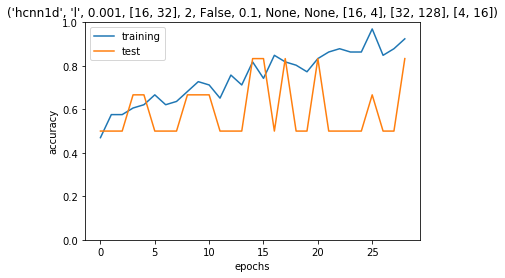

In [130]:
plot(1,train_metrics,None,test_metrics,False)

In [39]:
def ReshapeAndVote(model_train_predictions,round_before_voting=True):
    """used to fuse the predictions of n_models models after n_CV CV"""
    n_CV=len(model_train_predictions[0])
    n_models=len(model_train_predictions)
    if round_before_voting:
        reshaped_train_predictions=[[np.around(model_train_predictions[i][j]) for i in range(n_models)] for j in range(n_CV)]
    else:
        reshaped_train_predictions=[[model_train_predictions[i][j] for i in range(n_models)] for j in range(n_CV)]

    voted_train_predictions=[np.around(np.mean(reshaped_train_predictions[i],axis=0)) for i in range(n_CV)]
    return voted_train_predictions

In [20]:
fold_train_metrics,fold_test_metrics=MajorityVoting(model_train_predictions,model_test_predictions)

tram ; hsclstm ; 0.0001  ; [32, 8] ; [16] ; [1997] ; 2 ; [4] ; False; 0.2  ; None ; 28.00 (± 0.00); 61 ; False ; False ; False ; False ; False ; False ; NA ; 1 ; TRUE ; FALSE  ; 0.83 (± 0.05) ; NA ; 0.73 (± 0.13) ; 0.58 (± 0.23) ; 0.88 (± 0.15) ; 0.87 (± 0.18) ; 0.70 (± 0.13)  ; 5 ; 7 ; 8 ; 9 ; 13 ; 14 ; 17 ; 20 ; 26 ; 35 ; 36 ; 37 ; 42 ; 46 ; 54 ; 55 ; 58 ; 65 ; 70


# Visualization

### Load results

In [2]:
load_results=True

In [21]:
if load_results:
    patience=10
    n_epochs=100
    model_name="('_cnn1d', 'porovnat', None, 0.001, [16, 8, 64, 64], 4, False, 0.5, None, None, [8, 8, 2, 5], [64, 3, 1, 1], [16, 1, 2, 1])"
    filename=join("experiments",model_name)
    early_stopping=False
    metrics=[]
    for metric_type in ["train","test"]:
        with open (filename+metric_type, 'rb') as fp:
            metrics.append(pickle.load(fp))

    fold_train_metrics, fold_test_metrics=metrics

In [22]:
if early_stopping:
    avg_train=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_train_metrics]),axis=0)
    avg_valid=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_valid_metrics]),axis=0)
    avg_test=np.mean(np.asarray([fold[0:shortest_fold] for fold in fold_test_metrics]),axis=0)
else:
    avg_train=np.mean(fold_train_metrics,axis=0)
    #avg_valid=np.mean(fold_valid_metrics,axis=0)
    avg_test=np.mean(fold_test_metrics,axis=0)
    

('_cnn1d'| 'porovnat'| None| 0.001| [16| 8| 64| 64]| 4| False| 0.5| None| None| [8| 8| 2| 5]| [64| 3| 1| 1]| [16| 1| 2| 1])


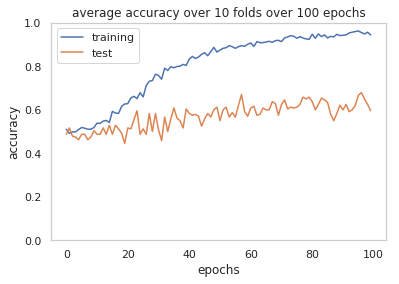

In [23]:
plot(1,avg_train,None,avg_test)

('_cnn1d'| 'porovnat'| None| 0.001| [16| 8| 64| 64]| 4| False| 0.5| None| None| [8| 8| 2| 5]| [64| 3| 1| 1]| [16| 1| 2| 1])


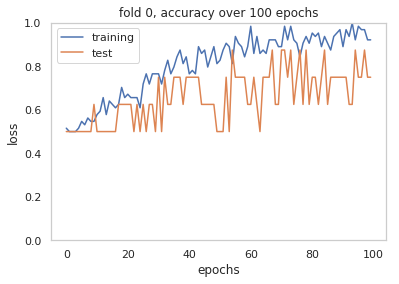

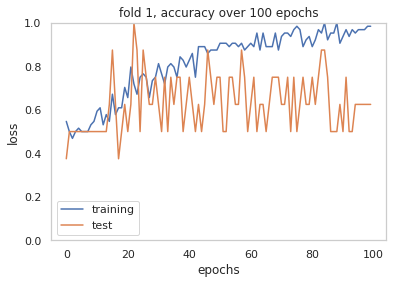

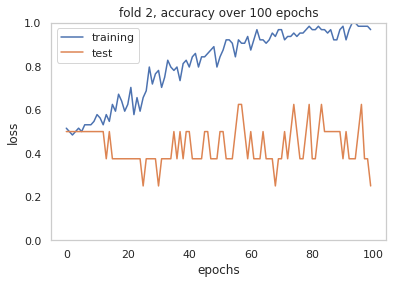

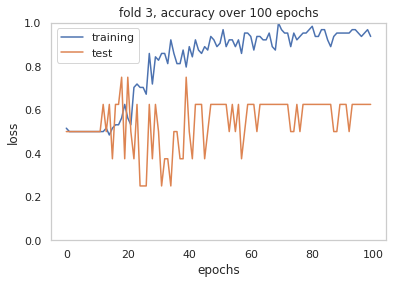

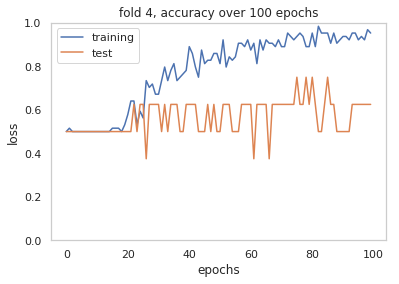

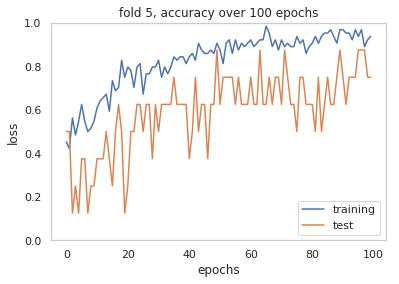

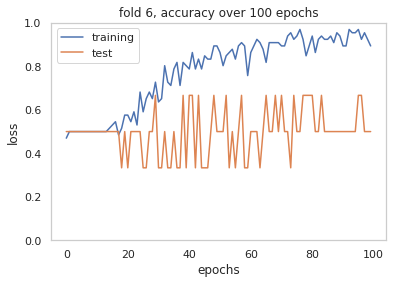

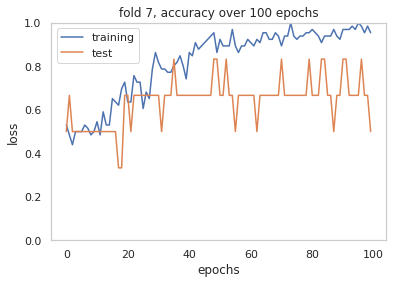

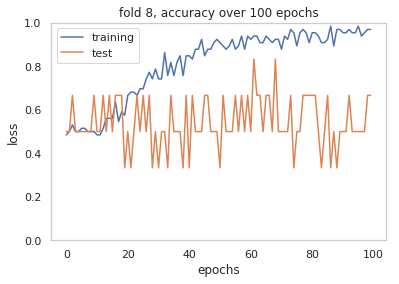

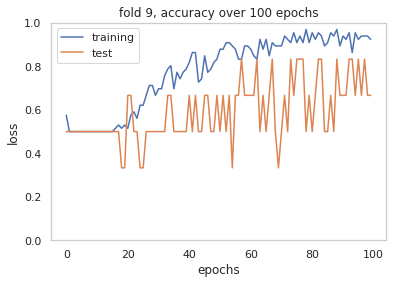

In [24]:
print(model_name.replace(",","|"))
for i in range(10):
    plt.figure()
    plt.title("fold {}, accuracy over {} epochs".format(i,len(fold_train_metrics[i])))
    plt.plot(np.asarray(fold_train_metrics[i])[:,1],label="training")
    plt.plot(np.asarray(fold_test_metrics[i])[:,1],label="test")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.ylim(0,1)
    plt.legend()

In [17]:
model_names=[]
for task_name,task_i in task2index.items():
    model_names.append("('hsclstm', '{}', 0.0001, [32, 8], 2, False, 0.2, None, None, [16], [{}], [4])".format(task_name,
                                                                                                              stroke_lengths[task_i]-60))
    

In [18]:
model_names

["('hsclstm', 'spiral', 0.0001, [32, 8], 2, False, 0.2, None, None, [16], [16011], [4])",
 "('hsclstm', 'l', 0.0001, [32, 8], 2, False, 0.2, None, None, [16], [692], [4])",
 "('hsclstm', 'le', 0.0001, [32, 8], 2, False, 0.2, None, None, [16], [1044], [4])",
 "('hsclstm', 'les', 0.0001, [32, 8], 2, False, 0.2, None, None, [16], [1416], [4])",
 "('hsclstm', 'lektorka', 0.0001, [32, 8], 2, False, 0.2, None, None, [16], [3508], [4])",
 "('hsclstm', 'porovnat', 0.0001, [32, 8], 2, False, 0.2, None, None, [16], [1997], [4])",
 "('hsclstm', 'nepopadnout', 0.0001, [32, 8], 2, False, 0.2, None, None, [16], [2207], [4])",
 "('hsclstm', 'tram', 0.0001, [32, 8], 2, False, 0.2, None, None, [16], [1171], [4])"]

In [19]:
model_train_predictions,model_test_predictions=[],[]

for m_name in model_names[1:]:    
    filename=join("predictions",m_name)
    with open (filename+"train", 'rb') as fp:
        model_train_predictions.append(pickle.load(fp))
    with open (filename+"test", 'rb') as fp:
        model_test_predictions.append(pickle.load(fp))


('cnn1d'| 'spiral'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'l'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'le'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'les'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'lektorka'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'porovnat'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'nepopadnout'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'tram'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])
('cnn1d'| 'tram'| 0.001| [50]| 1| False| 0.2| None| None| [1]| [16071]| [1])


Text(0.5, 1.0, 'Majority voting, 10 CV accuracy')

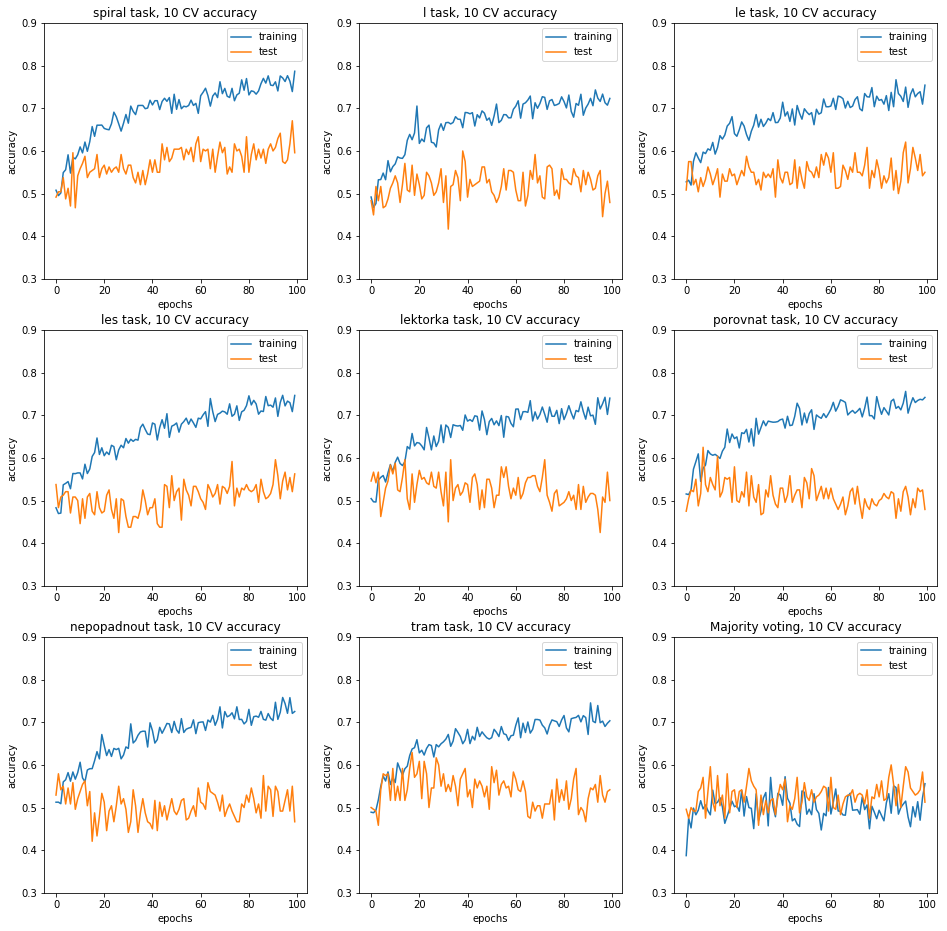

In [144]:

plt.figure(figsize=(14,14))
#for task_name,task_i in task2index.items():
for task_i,model_name in enumerate(model_names):
    task_name=model_name.split(",")[1]
    plt.subplot(2,2,task_i+1)
    #model_name="('cnn1d', '{}', 0.001, [50], 1, False, 0.2, None, None, [1], [16071], [1])".format(task_name)
    filename=join("experiments",model_name)
    metrics=[]
    for metric_type in ["train","test"]:
        with open (filename+metric_type, 'rb') as fp:
            metrics.append(pickle.load(fp))

    fold_train_metrics, fold_test_metrics=metrics
    
    model_metrics.append(fold_test_metrics)
    print_results(fold_train_metrics, fold_test_metrics,[],best_index=65)
    avg_train=np.mean(fold_train_metrics,axis=0)
    #avg_valid=np.mean(fold_valid_metrics,axis=0)
    avg_test=np.mean(fold_test_metrics,axis=0)
    
    plot(1,avg_train,None,avg_test)
    plt.title(task_name+" task, 10 CV accuracy")
plt.subplot(2,2,task_i+2)
plot(1,np.mean(vote_train_metrics,axis=0),None,np.mean(vote_test_metrics,axis=0))

plt.title("Majority voting, 10 CV accuracy")

##  Interpretation

### Model weights
#### CNNs

In [34]:
on_paper=model.conv1.weight.squeeze().cpu().detach().numpy()

In [35]:
on_paper.shape

(16, 7, 16)

ValueError: num must be 1 <= num <= 6, not 7

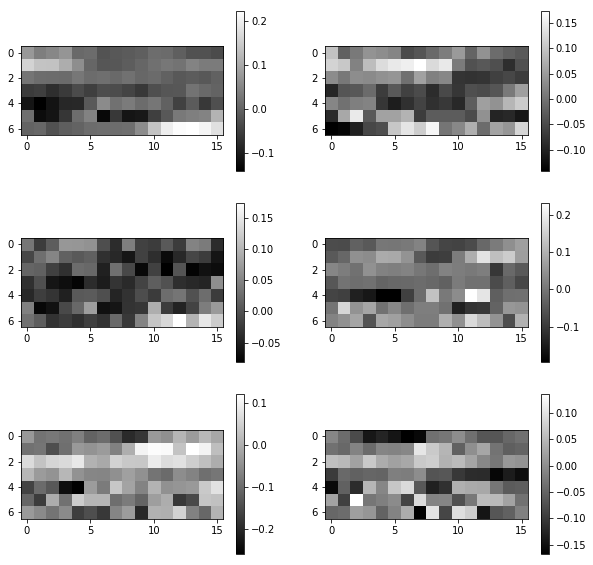

In [36]:
plt.figure(figsize=(10,10))
for j in range(on_paper.shape[0]):
    plt.subplot(3,2,j+1)
    plt.imshow(on_paper[j],cmap="gray")
    plt.colorbar()


Text(0, 0.5, 'average activation')

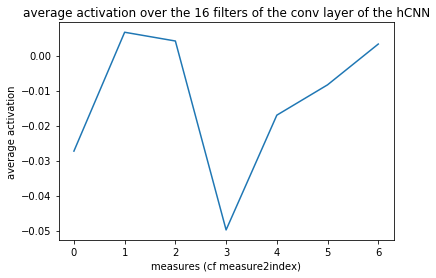

In [40]:
plt.plot(np.mean(np.mean(on_paper,axis=0),axis=1))
plt.title("average activation over the 16 filters of the conv layer of the hCNN")
plt.xlabel("measures (cf measure2index)")
plt.ylabel("average activation")

Text(0, 0.5, 'average activation')

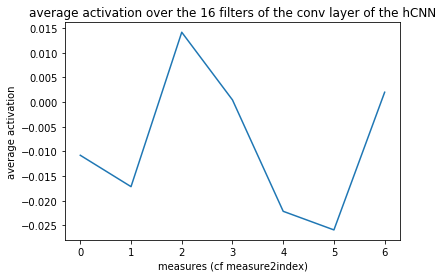

In [41]:
plt.plot(np.mean(np.mean(in_air,axis=0),axis=1))
plt.title("average activation over the 16 filters of the conv layer of the hCNN")
plt.xlabel("measures (cf measure2index)")
plt.ylabel("average activation")

In [109]:
subject=[torch.Tensor(seq.copy()).unsqueeze(0).transpose(1,2).to(device) for seq in data[8]]

model(subject)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [107]:
model=HierarchicalStrokeCRNN(input_size,conv_seq_len,hidden_size
                                    ,conv_kernel,pool_kernel  ,padding,stride,dilation, dropout,output_size)

In [111]:
model=model.to(device)

In [38]:
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(data,targets)

for fold,(train_index,test_index) in enumerate(cv_generator): 
    print(fold,test_index,[targets[i] for i in test_index])

0 [ 3 25 41 43 58 63 65 69] [1, 0, 1, 1, 1, 0, 0, 0]
1 [17 19 21 30 48 50 52 56] [1, 1, 1, 1, 0, 0, 0, 0]
2 [36 37 42 57 61 62 64 68] [1, 1, 1, 1, 0, 0, 0, 0]
3 [ 2  4 24 26 31 35 59 60] [1, 1, 0, 0, 1, 1, 0, 0]
4 [10 14 29 38 45 53 55 67] [1, 1, 1, 0, 0, 0, 1, 0]
5 [ 6 18 20 28 49 51 54 66] [1, 1, 1, 0, 0, 0, 1, 0]
6 [ 7 13 32 44 70 71] [1, 1, 0, 0, 0, 1]
7 [ 0  1 16 22 23 47] [1, 1, 1, 0, 0, 0]
8 [ 5 11 15 27 39 46] [1, 1, 1, 0, 0, 0]
9 [ 8  9 12 33 34 40] [1, 1, 1, 0, 0, 0]


In [152]:
j=0

In [162]:
print(model(torch.Tensor(data[40][j]).unsqueeze(0).transpose(1,2).to(device)))
j+=1

IndexError: list index out of range

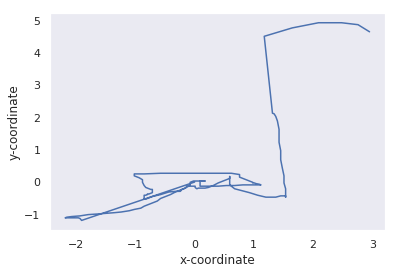

In [77]:
plot_task(data[8][5])

In [112]:
save_feats=[]
save_convs=[]
for seq in subject:
    if seq[0,measure2index["button_status"],0]==on_paper_value:
        
        c1=model.conv1(seq)
    else:
        c1=model.conv1_air(seq)
    r1=model.relu1(c1)
    save_convs.append(r1)
    p1=model.pool1(r1)   
    save_feats.append(p1)
    """drop1=model.drop1(p1)        
    c2=model.conv2(drop1)
    r2=model.relu2(c2)
    p2=model.pool2(r2)
    #flatten
    flat=p2.view(p2.size(0), -1)
    save_flat.append(flat)"""
#cat=torch.cat(save_flat,dim=1)
cat=torch.cat(save_feats,dim=2)

In [113]:
cat.shape

torch.Size([1, 16, 9])

In [114]:
cat.transpose(1,2).shape

torch.Size([1, 9, 16])

In [120]:
rnn_out,last_hidden=model.rnn(cat.transpose(1,2))

In [122]:
last_hidden[0].shape

torch.Size([1, 1, 32])

In [119]:
rnn_out[:,-1].shape

torch.Size([1, 32])

In [33]:
save_feats=[]
save_convs=[]
for seq in subject:
    if seq[0,measure2index["button_status"],0]==on_paper_value:
        
        c1=model.conv1(seq)
    else:
        c1=model.conv1_air(seq)
    r1=model.relu1(c1)
    save_convs.append(r1)
    p1=model.pool1(r1)   
    save_feats.append(p1)
    """drop1=model.drop1(p1)        
    c2=model.conv2(drop1)
    r2=model.relu2(c2)
    p2=model.pool2(r2)
    #flatten
    flat=p2.view(p2.size(0), -1)
    save_flat.append(flat)"""
#cat=torch.cat(save_flat,dim=1)
cat=torch.cat(save_feats,dim=2)
drop1=model.drop1(cat)        
c2=model.conv2(drop1)
r2=model.relu2(c2)
p2=model.pool2(r2)

'plt.figure(figsize=(16,12))\nfor j in [4]:\n    plt.subplot(3,3,j+1)\n    plt.title("filter {}".format(j))\n    plt.plot(r1.squeeze().cpu().detach().numpy()[j,:trim_to])'

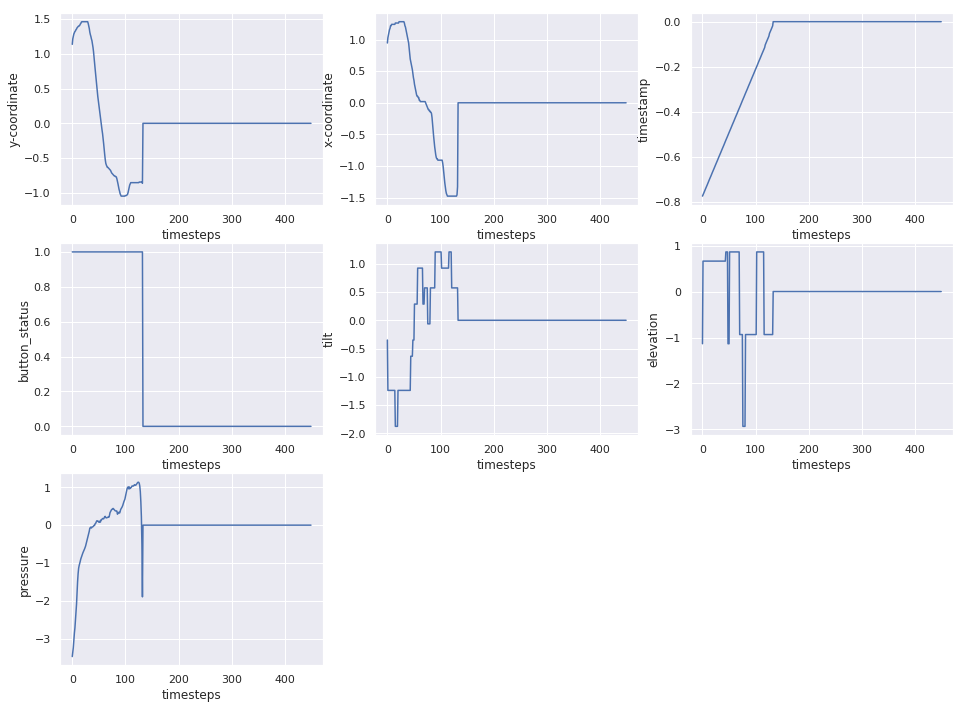

In [34]:
trim_to=450
plot_measures(data[8][0][:trim_to])
"""plt.figure(figsize=(16,12))
for j in [4]:
    plt.subplot(3,3,j+1)
    plt.title("filter {}".format(j))
    plt.plot(r1.squeeze().cpu().detach().numpy()[j,:trim_to])"""

Text(0.5, 0, 'timesteps')

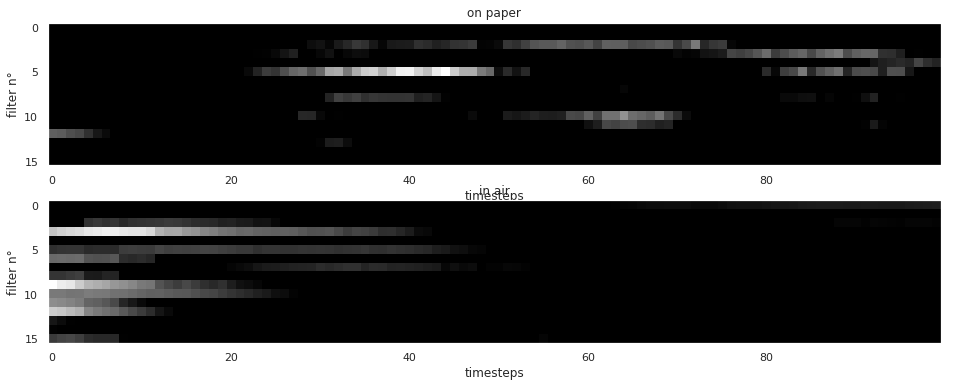

In [66]:
plt.figure(figsize=(16,6))
plt.subplot(2,1,1)
plt.title("on paper")
plt.imshow(save_convs[0].squeeze().cpu().detach().numpy()[:,:trim_to],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")
plt.subplot(2,1,2)
plt.title("in air")
plt.imshow(save_convs[1].squeeze().cpu().detach().numpy()[:,:trim_to],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")

IndexError: index 20 is out of bounds for axis 0 with size 16

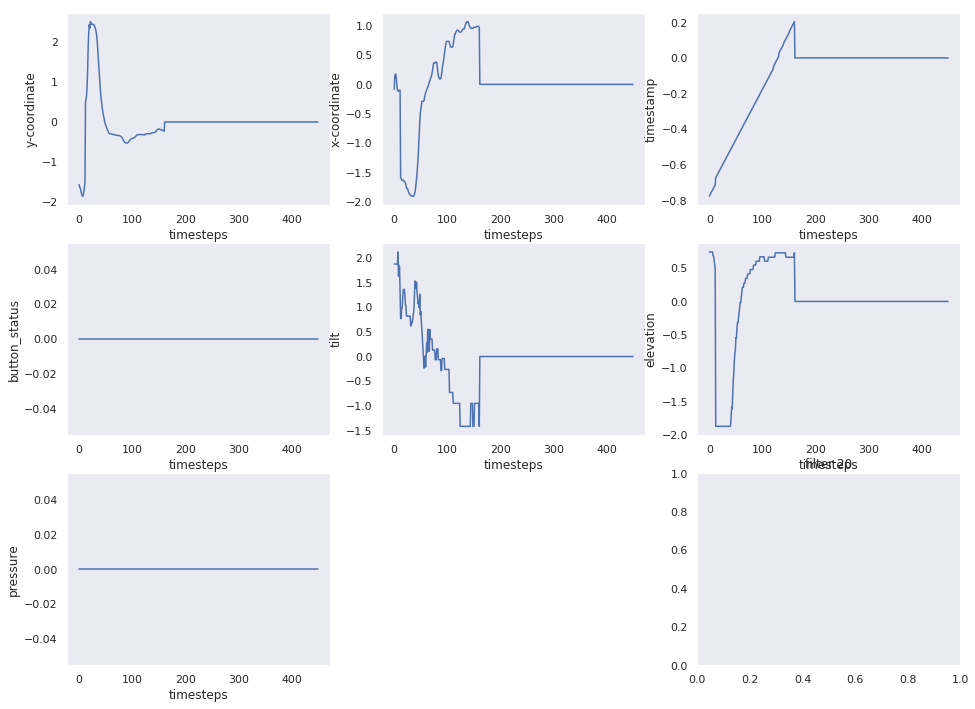

In [70]:
trim_to=450
plot_measures(data[8][1][:trim_to])
#plt.figure(figsize=(16,12))
for j in [20]:
    plt.subplot(3,3,9)
    plt.title("filter {}".format(j))
    plt.plot(r1.squeeze().cpu().detach().numpy()[j,:trim_to])

In [67]:
trim_to=None

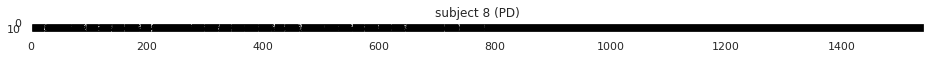

In [68]:
plt.figure(figsize=(16,10))
plt.title("subject 8 (PD)")
plt.imshow(cat.squeeze().cpu().detach().numpy()[:,:trim_to],cmap="gray")

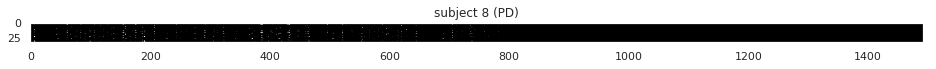

In [69]:
plt.figure(figsize=(16,6))
plt.title("subject 8 (PD)")
plt.imshow(r2.squeeze().cpu().detach().numpy()[:,:trim_to],cmap="gray")

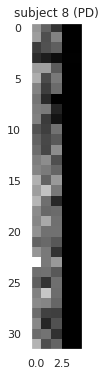

In [65]:
plt.figure(figsize=(16,6))
plt.title("subject 8 (PD)")
plt.imshow(p2.squeeze(0).cpu().detach().numpy()[:,:],cmap="gray")

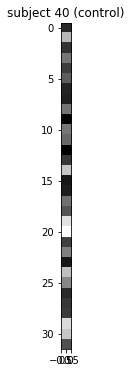

In [85]:
plt.figure(figsize=(16,6))
plt.title("subject 40 (control)")
plt.imshow(p2.squeeze(0).cpu().detach().numpy()[:,:],cmap="gray")

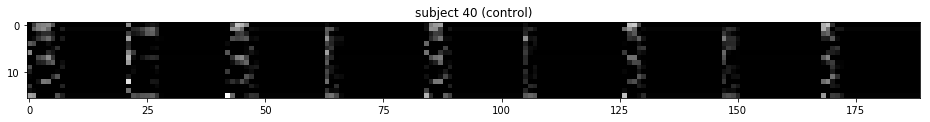

In [84]:
plt.figure(figsize=(16,6))
plt.title("subject 40 (control)")
plt.imshow(cat.squeeze().cpu().detach().numpy()[:,:],cmap="gray")

Text(0.5, 0, 'timesteps')

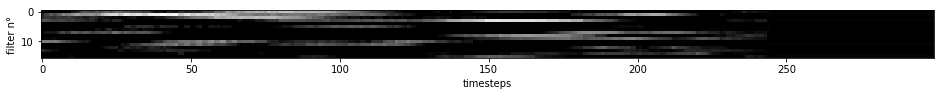

In [125]:
plt.figure(figsize=(16,12))

#plt.title("subject n°8 (PD, wrongly classified)")
plt.imshow(r1.squeeze().cpu().detach().numpy()[:,:300],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")

Text(0.5, 0, 'timesteps')

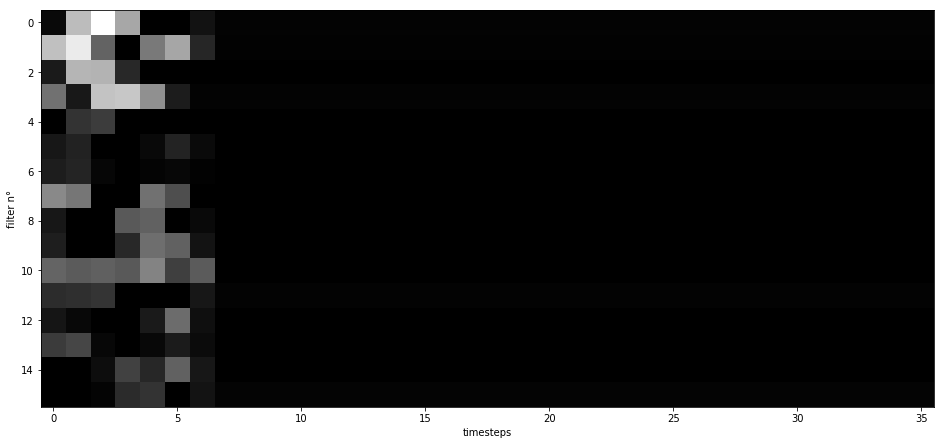

In [90]:
plt.figure(figsize=(16,12))

#plt.title("subject n°8 (PD, wrongly classified)")
plt.imshow(p1.squeeze().cpu().detach().numpy()[:,:300],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")

Text(0.5, 0, 'timesteps')

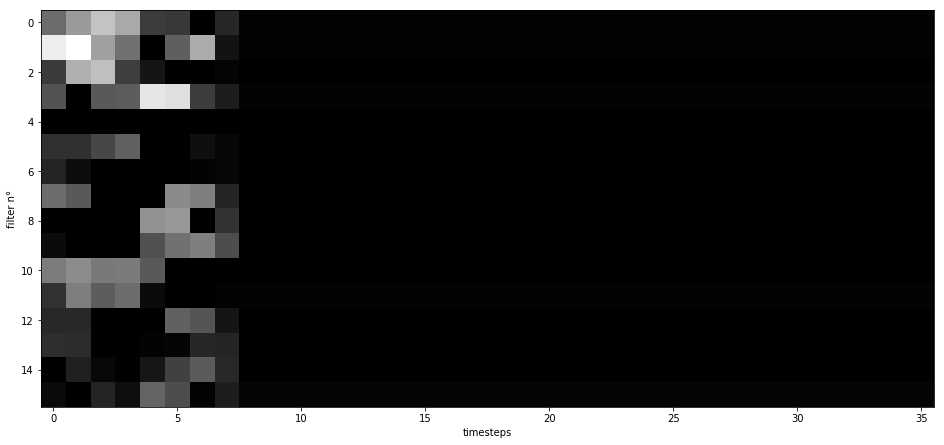

In [126]:
plt.figure(figsize=(16,12))

#plt.title("subject n°8 (PD, wrongly classified)")
plt.imshow(p1.squeeze().cpu().detach().numpy()[:,:300],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")

Text(0.5, 0, 'timesteps')

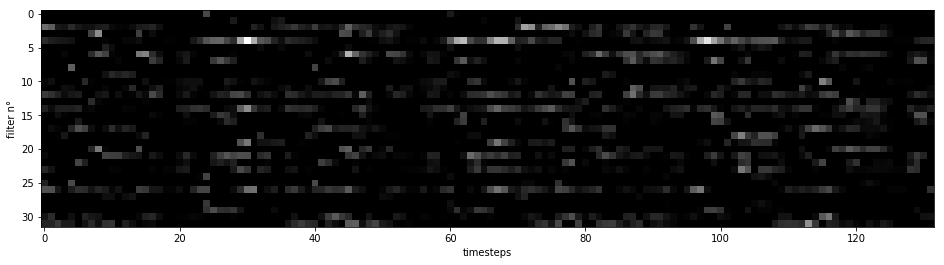

In [91]:
plt.figure(figsize=(16,12))

#plt.title("subject n°8 (PD, wrongly classified)")
plt.imshow(r2.squeeze().cpu().detach().numpy()[:,:300],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")

Text(0.5, 0, 'timesteps')

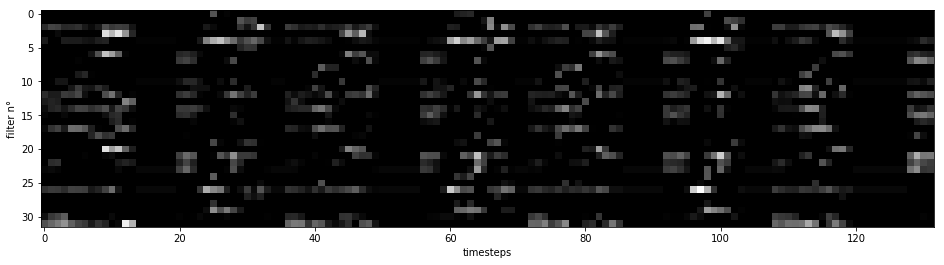

In [127]:
plt.figure(figsize=(16,12))

#plt.title("subject n°8 (PD, wrongly classified)")
plt.imshow(r2.squeeze().cpu().detach().numpy()[:,:300],cmap="gray")
plt.ylabel("filter n°")
plt.xlabel("timesteps")

Text(0, 0.5, 'activation')

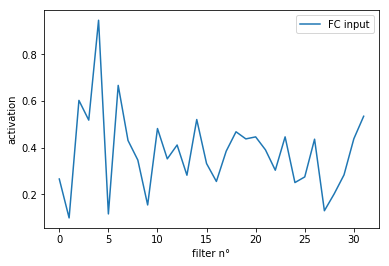

In [114]:


#plt.title("subject n°8 (PD, wrongly classified)")
plt.plot(p2.squeeze(0).cpu().detach().numpy()/5,label="FC input")
#plt.plot(model.linear1.weight.squeeze(0).cpu().detach().numpy(),label="FC weight")
plt.legend()
plt.xlabel("filter n°")
plt.ylabel("activation")

Text(0, 0.5, 'activation')

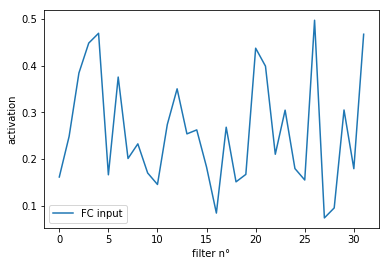

In [130]:


#plt.title("subject n°8 (PD, wrongly classified)")
plt.plot(p2.squeeze(0).cpu().detach().numpy()/5,label="FC input")
#plt.plot(model.linear1.weight.squeeze(0).cpu().detach().numpy(),label="FC weight")
plt.legend()
plt.xlabel("filter n°")
plt.ylabel("activation")

#### RNNs

In [11]:
print("""the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size) if LSTM and 
(W_ir|W_iz|W_in) of shape (3*hidden_size x input_size) if GRU""")
print(model.encoder.weight_ih_l0.shape)#lstm.weight_ih_l0.shape)
input_weights=model.encoder.weight_ih_l0.cpu().detach().numpy()

the learnable input-hidden weights of the kth layer (W_ii|W_if|W_ig|W_io) (with k=0 in our case),
of shape (4*hidden_size x input_size) if LSTM and 
(W_ir|W_iz|W_in) of shape (3*hidden_size x input_size) if GRU
torch.Size([30, 9])


[ 0.18169089 -0.04943112  0.06535473  0.01828056  0.01205595 -0.02092264
 -0.07480846  0.0185647  -0.0245374 ]
[ 0.03647731  0.05538079 -0.0206281   0.0765989   0.04889316  0.01612907
 -0.03662204  0.081875    0.05412391]
[ 0.02652793 -0.10414839 -0.0121935  -0.01399441  0.0030055   0.024525
 -0.09067195  0.10848202  0.10834714]


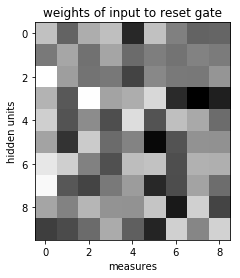

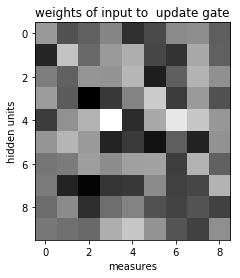

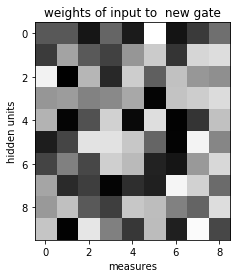

In [16]:
plot_labels="reset gate, update gate, new gate".split(",")
for i,label in enumerate(plot_labels):
    plt.figure()
    plt.title("weights of input to {}".format(label))
    plt.xlabel("measures")
    plt.ylabel("hidden units")
    print(np.mean(input_weights[i*10:i*10+10],axis=0))
    plt.imshow(input_weights[i*10:i*10+10],cmap='gray')v

#### Biases after init at 1


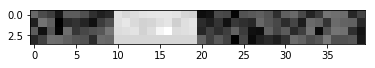

In [358]:
biases=[lstm.bias_hh_l0,
lstm.bias_hh_l0_reverse,
lstm.bias_hh_l1,
lstm.bias_hh_l1_reverse]
for i,b in enumerate(biases):
    biases[i]=b.cpu().detach().numpy()
plt.imshow(biases,cmap='gray')

###  Falses

<Figure size 432x288 with 0 Axes>

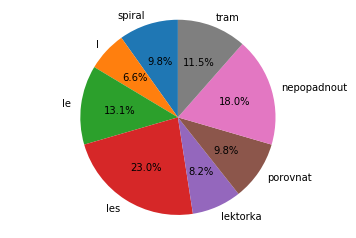

<Figure size 432x288 with 0 Axes>

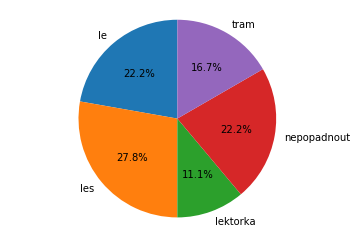

In [492]:
"""figure from the defect implementation !"""
for indexes in [test_index,fold_falses[-2][2]]:
    test_classes=np.argmax([data[i][0][0:8] for i in indexes],axis=1)
    unique,counts=np.unique(test_classes, return_counts=True)
    plt.figure()
    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = [index2task[i] for i in unique]
    sizes = counts
    
    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

### Experiments metrics

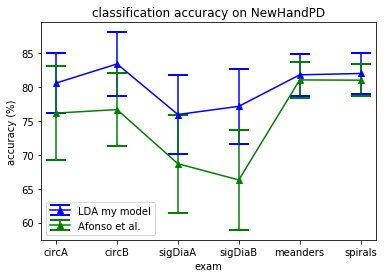

In [102]:
plt.figure()
plt.title("classification accuracy on NewHandPD")
plt.ylabel("accuracy (%)")
plt.xlabel("exam")
for i in [0,1]:
    plt.errorbar(exams[:-1],results[:,:,0][:,i],results[:,:,1][:,i],color=colors[i],label=labels[i], marker='^',capsize=10,capthick=2)
    plt.legend()
    #plt.errorbar(exams[:-1],[0.63,0.7,0.72],[0.16,0.15,0.1],label="layer size = 10", marker='^')

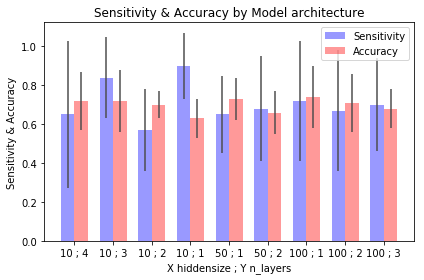

In [34]:
n_groups = len(results)

studied_metric = tuple([float(i[-1][0:5]) for i in results])#(0.74, 0.63, 0.7)
studied_std = tuple([float(i[-1][8:13]) for i in results])#(0.16, 0.1, 0.07)

accuracy_vanilla = tuple([float(i[-2][0:5]) for i in results])
std_vanilla = tuple([float(i[-2][8:13]) for i in results])

fig, ax = plt.subplots()

index = np.arange(n_groups)
bar_width = 0.35

opacity = 0.4
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index, studied_metric, bar_width,
                alpha=opacity, color='b',
                yerr=studied_std, error_kw=error_config,
                label='Sensitivity')

rects2 = ax.bar(index + bar_width, accuracy_vanilla, bar_width,
                alpha=opacity, color='r',
                yerr=std_vanilla, error_kw=error_config,
                label='Accuracy')

ax.set_xlabel('X hiddensize ; Y n_layers')
ax.set_ylabel('Sensitivity & Accuracy')
ax.set_title('Sensitivity & Accuracy by Model architecture')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(tuple([i[0]+" ; "+i[1] for i in results]))#('100 ; 1', '10 ; 1', '10 ; 2'))
ax.legend()

fig.tight_layout()
plt.show()

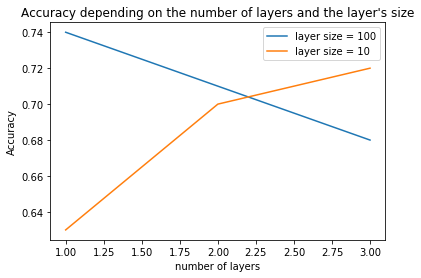

In [124]:
plt.figure()

plt.title("Accuracy depending on the number of layers and the layer's size")
plt.plot(range(1,4),[0.74,0.71,0.68],label="layer size = 100")
plt.plot(range(1,4),[0.63,0.7,0.72],label="layer size = 10")
#plt.errorbar(range(1,4),[0.74,0.71,0.68],[0.16,0.07,0.1],label="layer size = 100", marker='^')
#plt.errorbar(range(1,4),[0.63,0.7,0.72],[0.16,0.15,0.1],label="layer size = 10", marker='^')
plt.xlabel("number of layers")
plt.ylabel("Accuracy")
plt.legend()

# Implemented but not used

## Trimming and padding
For spirals we set max_len at 3117 as it's the 3rd quartile of task lengths (i.e. 3/4 subjects have task shorter than 3117 timesteps)

In [10]:
"""
if task_i is None:
    raise NotImplementedError("Multi-task learning is not implemented for trimming and padding")
max_len=3117
for i,task in enumerate(data):
    
    if len(task) > max_len:
        data[i]=task[:max_len]
    else:
        data[i]=np.concatenate((task,np.zeros(shape=(max_len-len(task),7))))"""
print("With this trimming and padding the model won't fit with the same hyperparameters")


With this trimming and padding the model won't fit with the same hyperparameters


## MAB Optim

In [199]:
actions={"increment":0,"idle":1,"decrement":2}
#pessimistic init (reward == loss)
qtable={"is_lstm":np.ones(len(actions)),"learning_rate":np.ones(len(actions)),
        "hidden_size":np.ones(len(actions)),
        "num_layers":np.ones(len(actions)),"bidirectional":np.ones(len(actions)),
        "dropout":np.ones(len(actions)),"clip":np.ones(len(actions))}

hyperparameters_range={"is_lstm":[True,False],
                 "learning_rate":[1e-2,1e-3,1e-4],
                 "hidden_size":[2**i for i in range (1,8)],
                 "num_layers":[i for i in range (1,6)],
                 "bidirectional":[True,False],
                 "dropout":np.arange(0,0.6,0.1),
                 "clip":[1,5,10,50,None]}
#index for hyperparameters_range
hyperparameters={"is_lstm":1,
                 "learning_rate":1,
                 "hidden_size":2,
                 "num_layers":1,
                 "bidirectional":0,
                 "dropout":2,
                 "clip":1}
q_decay_rate = 0.03
q_learning_rate = 0.5

In [170]:
episode = 0
experiments=[]
while True:
    q_exploration_rate=np.exp(-q_decay_rate*episode)#exploration rate update
    save_actions=[]#to update qtable later
    for p in hyperparameters.keys():#choose every hyperparam 
        
        #define what action the agent is able to take
        choose_from=[actions["idle"]]
        if hyperparameters[p]+1 < len(hyperparameters_range[p]):#if we can increment
            choose_from.append(actions["increment"])
        elif hyperparameters[p] > 0:#if we can decrement   
            choose_from.append(actions["decrement"])
            
        if np.random.rand()<q_exploration_rate:#exploration (i.e. random choice)
            action=np.random.choice(choose_from)
        else:
            #"removes" unallowed actions from the qtable
            #replace 1000 with 0 if optimizing accuracy
            allowed_table=[q if i in choose_from else 1000 for i,q in enumerate(qtable[p])]
            action=np.argmin(allowed_table)#argmin because we want to MINimize LOSS        
            
        if action==actions["increment"]:            
            hyperparameters[p]+=1
        elif action==actions["idle"]:
            pass#idle
        elif action==actions["decrement"]:
            hyperparameters[p]-=1
        else:
            raise ValueError("incorrect action index {},expected one of {}".format(action,actions))
        save_actions.append(action)#to update qtable later
    
    #take action (e.g. 10 CV)
    is_lstm=hyperparameters_range["is_lstm"][hyperparameters["is_lstm"]]
    learning_rate = hyperparameters_range["learning_rate"][hyperparameters["learning_rate"]]
    hidden_size=hyperparameters_range["hidden_size"][hyperparameters["hidden_size"]]
    num_layers=hyperparameters_range["num_layers"][hyperparameters["num_layers"]]
    bidirectional=hyperparameters_range["bidirectional"][hyperparameters["bidirectional"]]
    dropout=hyperparameters_range["dropout"][hyperparameters["dropout"]]
    clip=hyperparameters_range["clip"][hyperparameters["clip"]] 
    
    print("\nepisode n°{}, hyperparameters :\n {} ; {} ; {} ; {} ; {} ; {} ; {}".format(
    episode,is_lstm,learning_rate,hidden_size,num_layers,bidirectional,dropout,clip))
    
    verbose=False
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_generator=skf.split(data,targets)
    fold_train_metrics,fold_valid_metrics,fold_falses=[],[],[]
    start = time()
    np.random.seed(1)
    save_to_print=""
    fold=0
    n_epochs=50#max n° of epochs the model will be trained to
    patience = 10#n° of epochs without improvement during which the model will wait before stopping

    for train_index,test_index in cv_generator:     
        train_metrics,valid_metrics,falses=[],[],[]

        torch.manual_seed(1)#random seed for weights init
        model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                     dropout,bidirectional, batch_size, output_size, is_lstm)
        if isinstance(model.encoder,torch.nn.LSTM):
            model.init_forget_bias()
        model=model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        if fold==0:        
            print("(total n° of parameters, n° of trainable parameters)\n",model.count_params())

        best_accuracy=0
        #best_loss=10000.0
        impatience=0
        for i in range(n_epochs):                
            to_print=""
            np.random.shuffle(train_index)
            np.random.shuffle(test_index)
            #training
            model.train()
            [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, train_index,clip,validation=False)
            train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
            to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
            to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)

            #validation
            model.eval()
            [loss,accuracy,sensitivity,specificity,ppv,npv],false=epoch(
                data, targets, model, optimizer, loss_fn, batch_size, test_index,validation=True)    
            valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
            falses.append(false)
            to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
                loss,accuracy,sensitivity,specificity,ppv,npv)      

            #patience update        
            if accuracy <= best_accuracy:#`<=` no improvement is considered bad !#loss>=best_loss:
                impatience+=1
            else:
                best_accuracy=accuracy #best_loss=loss#
                impatience=0

            if verbose:
                print(to_print)
            save_to_print+=to_print

            #early stopping
            if impatience >= patience:
                save_to_print+="\nEarly stopped."
                break     

        fold_train_metrics.append(train_metrics)
        fold_valid_metrics.append(valid_metrics)
        fold_falses.append(falses)
        fold+=1
    if not verbose:
        print(to_print)#save_to_print)
    experiments.append((fold_train_metrics,fold_valid_metrics,fold_falses,is_lstm,learning_rate,hidden_size,
                       num_layers,bidirectional, dropout,clip))
    #take reward : average loss over the best folds
    if np.max([len(fold) for fold in fold_valid_metrics]) >= n_epochs:
        print("episode n°{}, Warning : the model didn't early stopped therefore we didn't selected the best metric")
    
    reward=np.mean(np.asarray([fold[-patience-1] for fold in fold_valid_metrics])[:,0])
    #update qtable
    for i,p in enumerate(qtable):
        action=save_actions[i]
        qtable[p][action]+=q_learning_rate*(reward-qtable[p][action])
    episode+=1
              

episode n°0, hyperparameters :
 False ; 0.001 ; 128 ; 4 ; True ; 0.4 ; 1
(total n° of parameters, n° of trainable parameters)
 (994689, 994689)


fold n°9, epoch n°18, spent 350m 10s
TRAINING : loss 1.187, accuracy 0.636
VALIDATION : loss 2.055, accuracy 0.500, sensitivity  0.667, specificity 0.333, ppv 0.500, npv 0.500
episode n°1, hyperparameters :
 False ; 0.001 ; 64 ; 5 ; True ; 0.4 ; 5
(total n° of parameters, n° of trainable parameters)
 (326081, 326081)


fold n°9, epoch n°10, spent 244m 37s
TRAINING : loss 0.708, accuracy 0.515
VALIDATION : loss 0.693, accuracy 0.500, sensitivity  1.000, specificity 0.000, ppv 0.500, npv 0.000
episode n°2, hyperparameters :
 False ; 0.001 ; 64 ; 4 ; True ; 0.5 ; 5
(total n° of parameters, n° of trainable parameters)
 (251585, 251585)


fold n°9, epoch n°10, spent 178m 54s
TRAINING : loss 0.703, accuracy 0.606
VALIDATION : loss 0.693, accuracy 0.500, sensitivity  1.000, specificity 0.000, ppv 0.500, npv 0.000
episode n°3, hyperparameters :
 True

KeyError: 'learning_rate'

# stratified 10 cv train valid test

## Discards measures
keep only `keep_measures`

In [32]:
keep_measures=np.array([measure2index["y-coordinate"],measure2index["x-coordinate"],
              measure2index["tilt"],measure2index["elevation"],measure2index["pressure"]])
for i in range(len(data)):
    data[i]=data[i][:,keep_measures]

## Reload dependencies

In [24]:
%load_ext autoreload
%autoreload 2

# EXCEL TO ARRAY

In [20]:
lines="""exam	LDA (my model)	Afonso et al.	Pereira et al. 2018
circA	80.61 ± (4.40)	76.17±6.92	68.04 ± 2.96
circB	83.43 ± (4.68)	76.69±5.38	73.41 ± 3.66
sigDiaA	75.96 ± (5.90)	68.69±7.26	73.59 ± 3.57
sigDiaB	77.17 ± (5.52)	66.30±7.38	76.32 ± 5.18
meanders	81.82 ± (3.13)	81.07±2.60	80.75 ± 2.08
spirals	82.02 ± (3.02)	81.03±2.40	78.26 ± 1.97
all	83.84 ± (3.26)	NA	95.74 ± 1.60""".replace("(","").replace(")","").split("\n")

lines=[line.split("\t") for line in lines]

lines=np.asarray(lines)

exams=lines[1:,0]

labels=lines[0,1:]

results=lines[1:-1,1:]

results

results=np.array(results).astype(float)

results

results[:,:,0][:,0]

results[:,:,1]

colors=["b","g","r"]

plt.figure()
plt.title("classification accuracy on NewHandPD")
plt.ylabel("accuracy (%)")
plt.xlabel("exam")
for i,_ in enumerate(labels):
    plt.errorbar(exams[:-1],results[:,:,0][:,i],results[:,:,1][:,i],color=colors[i],label=labels[i], marker='^',capsize=10,capthick=2)
    plt.legend()
    #plt.errorbar(exams[:-1],[0.63,0.7,0.72],[0.16,0.15,0.1],label="layer size = 10", marker='^')

#  early stopping

In [35]:
#split in train valid and test set
skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
cv_generator=skf.split(data,targets)
cv_matrix=[[tmp_index,test_index] for tmp_index,test_index in cv_generator]
for i,fold in enumerate(cv_matrix):
    #validate on the next fold test set (or on the first fold test set if last fold)
    #10 because 10 cross validation
    valid_index=cv_matrix[i+1][1] if i+1 < 10 else cv_matrix[0][2]
    #removes valid set from tmp_index
    train_index=[index for index in fold[0] if index not in valid_index]
    cv_matrix[i]=[train_index,valid_index,fold[1]]

run_CV=True#if False, breaks after one fold, else runs CV
#n° of epochs without improvement during which the model will wait before stopping (if early_stopping)
#useless if not early_stopping
patience = 10
verbose=False
fold_train_metrics,fold_valid_metrics,fold_test_metrics,fold_falses=[],[],[],[]
start = time()
np.random.seed(1)
save_to_print=""

for fold,(train_index,valid_index,test_index) in enumerate(cv_matrix): 
    
    n_epochs=50#max n° of epochs the model will be trained to
    early_stopping=True
    train_on_validation=False
    train_metrics,valid_metrics,test_metrics,falses=[],[],[],[]

    torch.manual_seed(1)#random seed for weights init
    model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                     dropout,bidirectional, batch_size,output_size, is_lstm).to(device)
    if isinstance(model,torch.nn.LSTM):
        model.init_forget_bias()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    if fold==0:        
        print("(total n° of parameters, n° of trainable parameters)")
        print(model.count_params())

    #best_accuracy=0
    best_loss=10000.0
    impatience=0
    i=0
    while i <n_epochs:               
        to_print=""
        np.random.shuffle(train_index)#shuffle training to facilitate SGD        
        #training
        model.train()
        [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
        data, targets, model, optimizer, loss_fn, batch_size, train_index,device=device,
            clip=clip,validation=False,window_size=window_size,task_i=task_i,augmentation=augmentation,paper_air_split=paper_air_split)
        train_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        to_print+="\n\nfold n°{}, epoch n°{}, spent {}".format(fold,i,timeSince(start))
        to_print+="\nTRAINING : loss {:.3f}, accuracy {:.3f}".format(loss,accuracy)

        #validate
        if train_on_validation:
            model.train()
        else:
            model.eval()
        [loss,accuracy,sensitivity,specificity,ppv,npv],_=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, valid_index,device=device,
            validation=train_on_validation,window_size=window_size,task_i=task_i,augmentation=augmentation,paper_air_split=paper_air_split)    
        valid_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        to_print+="\nVALIDATION : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
            loss,accuracy,sensitivity,specificity,ppv,npv)      

        if early_stopping:
            #patience update
            if loss>=best_loss :#accuracy <= best_accuracy:#`<=` no improvement is considered bad !
                impatience+=1
            else:
                best_loss=loss#best_accuracy=accuracy #
                impatience=0
                #save the best model
                directory = join("weights", model_name)
                if not exists(directory):
                    makedirs(directory)
                torch.save({
                    'epoch': i,
                    'model': model.state_dict(),
                    'opt': optimizer.state_dict(),
                    'loss': loss
                }, join(directory, '{}_{}_checkpoint.tar'.format(fold,i)))

        #test
        [loss,accuracy,sensitivity,specificity,ppv,npv],false=epoch(
            data, targets, model, optimizer, loss_fn, batch_size, test_index,device=device,
            validation=True,window_size=window_size,task_i=task_i,augmentation=False,paper_air_split=paper_air_split)    
        test_metrics.append([loss,accuracy,sensitivity,specificity,ppv,npv])
        falses.append(false)
        to_print+="\nTEST : loss {:.3f}, accuracy {:.3f}, sensitivity  {:.3f}, specificity {:.3f}, ppv {:.3f}, npv {:.3f}".format(
            loss,accuracy,sensitivity,specificity,ppv,npv)  
        
        if verbose:
            print(to_print)
        save_to_print+=to_print
        #early stopping
        if impatience >= patience and early_stopping:
            save_to_print+="\nEarly stopped."
            early_stopping=False
            n_epochs=i+5#train for 5 more epochs on both training and validation set#break    
            train_on_validation=True
            #reload best model
            best_epoch=i-patience
            load_model = join("weights", #parent directory
                                model_name,#model type
                                '{}_{}_checkpoint.tar'.format(fold,best_epoch)#epoch to load at
                               )
            checkpoint = torch.load(load_model)
            model_sd = checkpoint['model']
            optimizer_sd = checkpoint['opt']
            model=Model(input_size, hidden_size,num_layers, bias,batch_first,
                             dropout,bidirectional, batch_size,output_size, is_lstm).to(device)
            model.load_state_dict(model_sd)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            optimizer.load_state_dict(optimizer_sd)
        i+=1#next epoch
    fold_train_metrics.append(train_metrics)
    fold_valid_metrics.append(valid_metrics)
    fold_test_metrics.append(test_metrics)
    fold_falses.append(falses)
    if not run_CV:
        break
early_stopping=True
n_epochs=50
if not verbose:
    print(to_print)#save_to_print)

if run_CV:   
    # Save metrics
    filename=join("experiments",model_name)
    for metrics,metric_type in list(zip([fold_train_metrics,
    fold_test_metrics],["train","test"])):
        with open(filename+metric_type, 'wb') as fp:
            pickle.dump(metrics, fp)
    
    shortest_fold=print_results()  

(total n° of parameters, n° of trainable parameters)
(2561, 2561)


KeyboardInterrupt: 

#  CNN avec liste de convs

In [7]:
class CNN1d(torch.nn.Module):
    def __init__(self,input_size,seq_len,hidden_size,kernel_size ,padding=0,stride=1,dilatation=1, dropout=0.0,output_size=1):
        super(CNN1d, self).__init__()
        
        blocks=[]
        out_size=seq_len
        for i in range(len(kernel_size)):
            input_size_ = input_size if i ==0 else hidden_size[i-1]
            out_size=(out_size+2*padding-dilatation*(kernel_size[i]-1)-1)//stride +1
            #print(out_size)
            out_size=(out_size+2*padding-dilatation*(2-1)-1)//2 +1
            #print(out_size)
            blocks+=[weight_norm(torch.nn.Conv1d(input_size_,hidden_size[i],kernel_size[i],stride,padding,dilatation)),
                torch.nn.ReLU(),
                torch.nn.MaxPool1d(2,2,padding,dilatation)]
            
        self.conv_layers=torch.nn.Sequential(*blocks)
        self.linear1=torch.nn.Linear(out_size*hidden_size[-1],20)
        self.drop1=torch.nn.Dropout(dropout)
        #self.linear2=torch.nn.Linear(20,10)
        #self.drop2=torch.nn.Dropout(dropout)
        #self.linear3=torch.nn.Linear(10,output_size)
        self.sigmoid=torch.nn.Sigmoid()
    def forward(self,subject):
        conv_out=self.conv_layers(subject)
        #flatten
        flat=conv_out.view(conv_out.size(0), -1)
        drop1=self.drop1(flat)
        l1=self.linear1(drop1)
        #l2=self.linear2(drop1)
        #drop2=self.drop2(l2)
        #l3=self.linear3(drop2)
        return self.sigmoid(l1)




# CV for majority voting
does not get the same results as CV for single model because `np.random.seed(1)` should be after the `for fold` loop

In [116]:
def CV(run_CV=True,n_epochs=100):
    """
    run_CV : if False, breaks after one fold, else runs CV
    n_epochs: max n° of epochs the model will be trained to
    """
    verbose=False
    fold_train_metrics,fold_test_metrics,fold_falses=[],[],[]
    model_metrics=np.zeros((2,#train = 0, test = 1
                            10,#10 fold
                            n_epochs,
                            8,#8 tasks (=) 8 models
                            6#6 metrics : loss,accuracy,sensitivity,specificity,ppv,npv
                           ))
    start = time()
    np.random.seed(1)
    start_at_fold=0#skip folds if > 0 and not run_CV
    skf = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_generator=skf.split(data,targets)

    for fold,(train_index,test_index) in enumerate(cv_generator): 

        if fold in np.arange(start_at_fold) and not run_CV:
            print("SKIPPING FOLD n°",fold)
            continue
        train_metrics,test_metrics,falses=[],[],[]

        hierarchical=False#except if model_type=="hcnn1d"
        models,optimizers=[],[]
        for m in range(8):
            torch.manual_seed(1)#random seed for weights init        
            if model_type=="tcn":
                model= TemporalConvNet(input_size,hidden_size,kernel_size,dropout,output_size=1,dilation_factor=dilation_factor)
            elif model_type=="lstm":
                model=Model(input_size, hidden_size[0],num_layers, bias,batch_first,
                             dropout,bidirectional, batch_size,output_size, is_lstm=True)
                model.init_forget_bias()
            elif model_type=="gru":
                model=Model(input_size, hidden_size[0],num_layers, bias,batch_first,
                             dropout,bidirectional, batch_size,output_size, is_lstm=False)
            elif model_type=="cnn1d":
                model=CNN1d(input_size,seq_len,hidden_size,conv_kernel,pool_kernel ,
                            padding,stride,dilation, dropout,output_size,-1)
            elif model_type=="hcnn1d":
                hierarchical=True
                model=HierarchicalCNN1d(input_size,seq_len,hidden_size
                                        ,conv_kernel,pool_kernel  ,padding,stride,dilation, dropout,output_size,fold)            
            else:
                raise ValueError("got {} as model_type but expected one of {}".format(model_type,models))
            model=model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
            models.append(model)
            optimizers.append(optimizer)
        if fold==0:        
            print("(total n° of parameters, n° of trainable parameters) :")
            print(count_params(model))   
            print("architecture :")
            print(model)
        for i in range(n_epochs):  
            np.random.shuffle(train_index)#shuffle training to facilitate SGD      
            train_predictions,test_predictions=[],[]
            for m, model in enumerate(models):
                #training
                model.train()
                predictions,loss=epoch(
                data[:,m], targets, model, optimizers[m], loss_fn, batch_size, train_index,device=device,
                    clip=clip,validation=False,window_size=window_size,task_i=task_i,augmentation=augmentation,
                    paper_air_split=paper_air_split,hierarchical=hierarchical)
                train_predictions.append(predictions)
                #compute model metrics
                tn, fp, fn, tp, _ = confusion_matrix(y_true=targets[train_index],y_pred=predictions)
                accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)                
                model_metrics[0,fold,i,m]=[loss,accuracy,sensitivity,specificity,ppv,npv]
                
                #test
                model.eval()
                predictions,loss=epoch(
                    data[:,m], targets, model, optimizers[m], loss_fn, batch_size, test_index,device=device,
                    validation=True,window_size=window_size,task_i=task_i,augmentation=False,
                    paper_air_split=paper_air_split,hierarchical=hierarchical)    
                test_predictions.append(predictions)
                #compute metrics
                tn, fp, fn, tp, false_i = confusion_matrix(y_true=targets[test_index],y_pred=predictions)
                accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn)
                model_metrics[1,fold,i,m]=[loss,accuracy,sensitivity,specificity,ppv,npv]
             
            #majority voting
            train_predictions=np.mean(train_predictions,axis=0)
            train_predictions=list(map(round,train_predictions))
            tn, fp, fn, tp, false_i = confusion_matrix(y_true=targets[train_index],y_pred=train_predictions)
            accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn) 
            train_loss=np.mean(model_metrics[0,fold,i,:,0])
            train_metrics.append([train_loss,accuracy,sensitivity,specificity,ppv,npv])
            
            test_predictions=np.mean(test_predictions,axis=0)
            test_predictions=list(map(round,test_predictions))
            tn, fp, fn, tp, false_i = confusion_matrix(y_true=targets[test_index],y_pred=test_predictions)
            accuracy,sensitivity,specificity,ppv,npv=return_metrics(tp,tn,fp,fn) 
            test_loss=np.mean(model_metrics[1,fold,i,:,0])
            test_metrics.append([test_loss,accuracy,sensitivity,specificity,ppv,npv])
            false=[test_index[i] for i in false_i]
            falses.append(false)

        fold_train_metrics.append(train_metrics)
        fold_test_metrics.append(test_metrics)
        fold_falses.append(falses)
        if not run_CV:
            return train_metrics,test_metrics,models,model_metrics

    if run_CV:   
        # Save metrics
        filename=join("experiments",model_name)
        for metrics,metric_type in list(zip([fold_train_metrics,
        fold_test_metrics],["train","test"])):
            with open(filename+metric_type, 'wb') as fp:
                pickle.dump(metrics, fp)

        shortest_fold,results=print_results(fold_train_metrics,fold_test_metrics,fold_falses) 
        with open("results.csv","a") as file:
            file.writelines(results+"\n")
        return fold_train_metrics,fold_test_metrics,models,model_metrics

# split tokens

(3, 0),(3, 1),(3, 2),(3, 3),(3, 4),(3, 5),(3, 6),(3, 7),(3, 8),(3, 9),(3, 10),(3, 11),(3, 12),

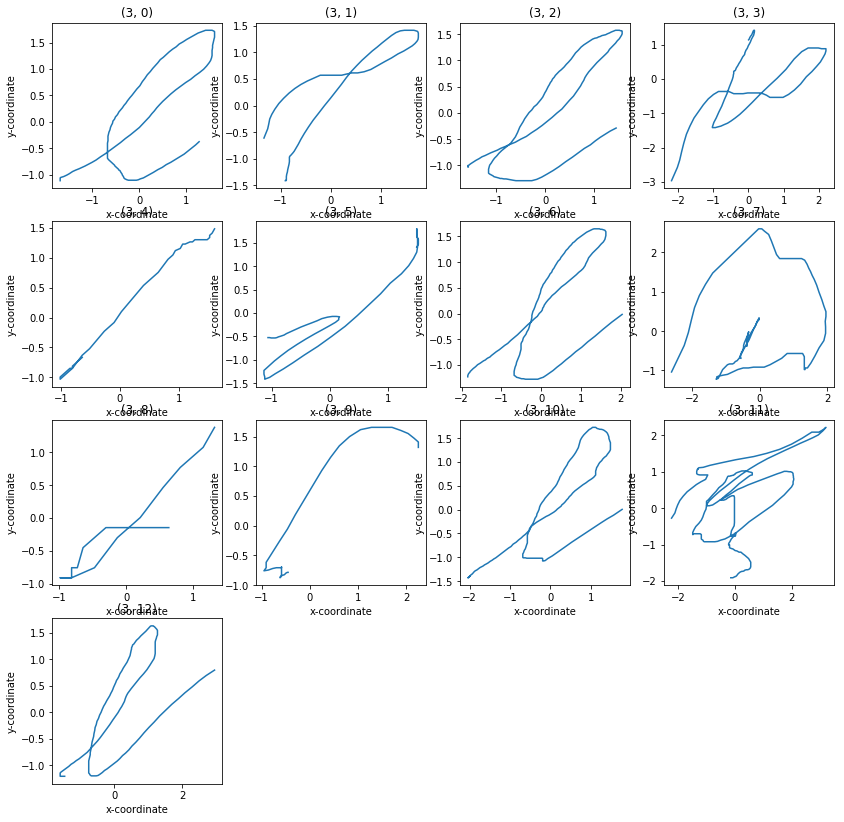

In [14]:



i=next(gen)
plt.figure(figsize=(14,14))
for j,sub in enumerate(data[i]):
    print((i,j),end=",")
    plt.subplot(4,4,j+1)
    plot_task(sub)
    plt.title((i,j))